In [ ]:

import cv2
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

In [16]:
import tensorflow as tf
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from skimage.io import imread

K.clear_session()

## IMAGE PROCESSSING
Let's understand the Data and Do some Stuffs

In [ ]:
img = plt.imread('r'D:\VIA\Project\app\data\Dataset\train\chapati\002.jpg'')
dims = np.shape(img)
dims

(167, 249, 3)

In [18]:
matrix = np.reshape(img , (dims[0] * dims[1] , dims[2]))
print(np.shape(matrix))

(41583, 3)


Image Shape:- (167, 249)
Color Channels:- 3
Min Color Depth : 0, Max Color Depth 255


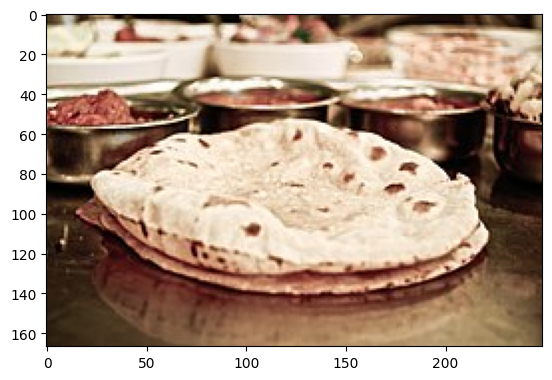

In [19]:
plt.imshow(img)
print("Image Shape:-" , dims[:2])
print("Color Channels:-", dims[2])
print("Min Color Depth : {}, Max Color Depth {}".format(np.min(img) , np.max(img)))

Plot for visualizing pixel intensities for RGB in color space


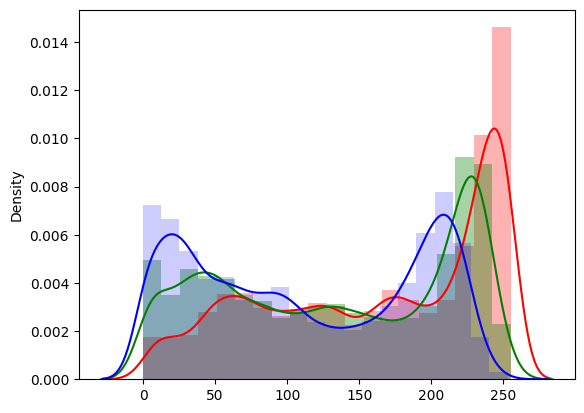

In [20]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

Plot for visualizing histogram between 2 color channel

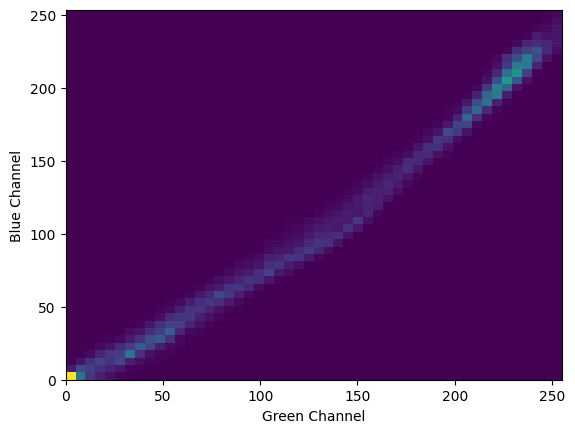

In [21]:
_ = plt.hist2d(matrix[:,1] , matrix[:,2] , bins = (50,50))
plt.xlabel("Green Channel")
plt.ylabel("Blue Channel")
plt.show()

 - The pixels between green and blue bands are correlated (as evident from overlapping on above graph), and typically has visible imagery.

 - Raw band differences will need to be scaled or thresholded

Image data consists of variations due to resolution differences between scenes, 
pixel intensities of an image and the environment around which the image was taken. 
This area of image processing is critical in today's time with the rise of Artificial 
intelligence.From motion detection to complex circuits in self driving car, 
the research requires tremendous amount of work and can be seen as widely growing areas of computer vision.

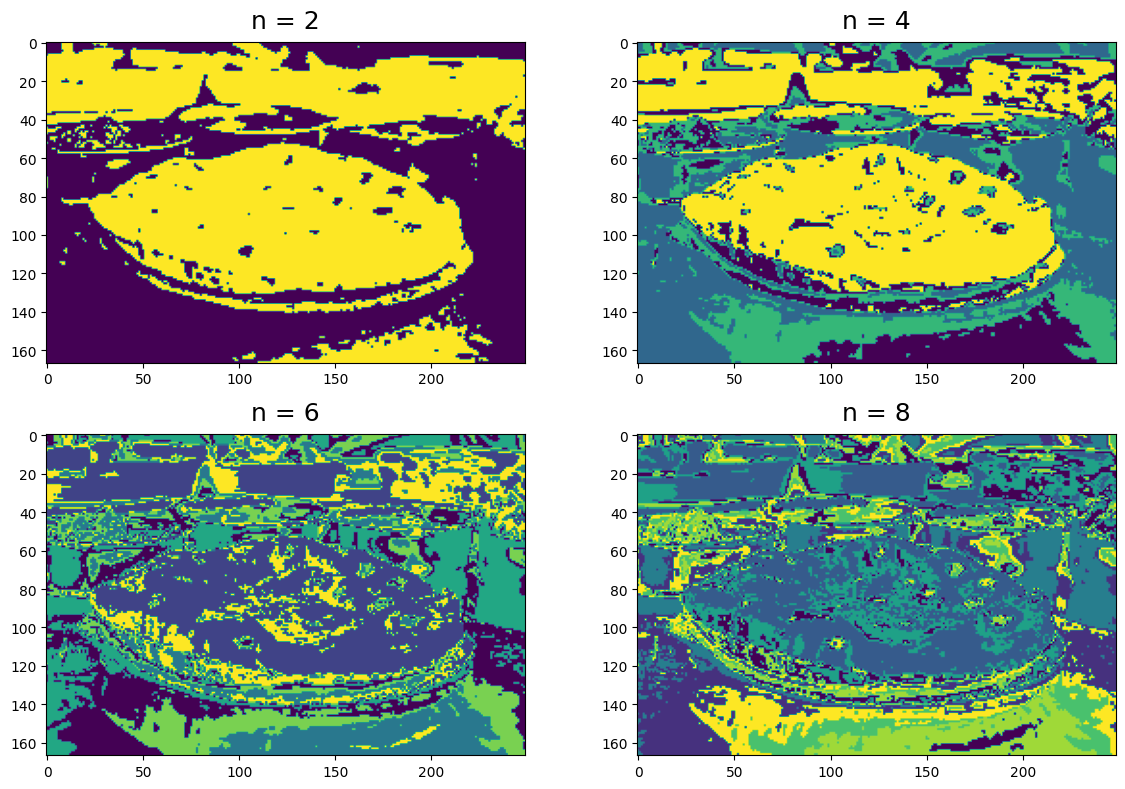

In [22]:
from sklearn import cluster
n_vals = [2,4,6,8]
plt.figure(1 , figsize = (12 , 8))

for subplot , n in enumerate(n_vals):
    kmeans = cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered , (dims[0] , dims[1]))
    plt.subplot(2,2, subplot+1)
    plt.title("n = {}".format(n) , pad = 10 , size = 18)
    plt.imshow(clustered_img)

plt.tight_layout()

# Exploratory Data Analysis (EDA)
Let's visualize number of training examples for each food item

In [1]:
# import os

# train = r'D:\VIA\Project\app\data\Dataset\train'

# data = dict()

# for i in os.listdir(train):
#     sub_dir = os.path.join(train , i)
#     count = len(os.listdir(sub_dir))
#     data[i] = count

# keys = data.keys()
# values = data.values()

# colors = ["red" if x<= 150 else "green" for x in values]

# fig , ax = plt.subplots(figsize = (12,8))
# y_pos = np.arange(len(values))
# plt.barh(y_pos , values , align = "center" , color=colors)
# for i , v in enumerate(values):
#     ax.text(v+1.4 , i-0.25 , str(v), color = colors[i])
# ax.set_yticks(y_pos)
# ax.set_yticklabels(keys)
# ax.set_xlabel('Images',fontsize=16)
# plt.xticks(color='black',fontsize=13)
# plt.yticks(fontsize=13)
# plt.show()  



 - Data augmentation helps with classes not having enough training
   examples by increasing the amount of relevant data in the dataset.

 - We would be doing what is known as **offline augmentation**. 
    It works on relatively smaller datasets, by increasing the 
    size of the dataset by a factor equal to the number of transformations you perform. 
    (For example, by flipping all my images, it would increase the size of the dataset by a factor of 2).

Let's visualize our dataset by randomly picking an image from every class

In [ ]:
import random

train_folder = r"D:\VIA\Project\app\data\Dataset\train"
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + "/" + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder , food_folder , food_selected))
    
    
fig = plt.figure(1 , figsize = (25,25))
for subplot , image_ in enumerate(images):
    category = image_.split("/")[-2]
    imgs = plt.imread(image_)
    a ,b, c = imgs.shape
    fig = plt.subplot(5 , 4 , subplot+1)
    fig.set_title(category , pad = 10 , size = 18)
    plt.imshow(imgs)
    
plt.tight_layout()

We discussed Data Augmentation before. Let's see how it works:
1. Accepting a batch of images used for training.

2. Taking this batch and applying a series of random transformations to each image in the batch. (including random rotation, resizing, shearing, etc.)

3. Replacing the original batch with the new, randomly transformed batch.

4. Training the CNN on this randomly transformed batch. (i.e, the original data itself is not used for training)

## Model Training and Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 20
batch_size = 32
img_width , img_height = 299 , 299

train_data_dir = r'D:\VIA\Project\app\data\Dataset\train'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)


val_data_dir = r'D:\VIA\Project\app\data\Dataset\val'
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3996 images belonging to 20 classes.
Found 1250 images belonging to 20 classes.


In [ ]:
class_map = train_generator.class_indices
class_map

## Training the model


# cnnv1

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.regularizers import l2

image_size = [299, 299, 3]
n_classes = 20  
batch_size = 32  
nb_train_samples = 3583
nb_valid_samples = 1089

input_layer = Input(shape=image_size)

x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='valid')(input_layer)
x = BatchNormalization()(x)

x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = Conv2D(80, (1, 1), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)

x = Conv2D(192, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes, kernel_regularizer=l2(0.005), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoints = ModelCheckpoint(filepath="cnnv1.keras", verbose=1, save_best_only=True)
csv_logger = CSVLogger("history_cnnv1.log")

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator,
    validation_steps=nb_valid_samples // batch_size,
    epochs=20,
    verbose=1,
    callbacks=[csv_logger, checkpoints]
)


Epoch 1/20


I0000 00:00:1731999000.877797     321 service.cc:145] XLA service 0x7a58540088c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731999000.877853     321 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731999000.877857     321 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/111 ━━━━━━━━━━━━━━━━━━━━ 47:53 26s/step - accuracy: 0.1071 - loss: 3.3987

I0000 00:00:1731999014.600159     321 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0757 - loss: 3.3154
Epoch 1: val_loss improved from inf to 3.20396, saving model to cnnv1.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.0759 - loss: 3.3141 - val_accuracy: 0.0267 - val_loss: 3.2040
Epoch 2/20
 14/111 ━━━━━━━━━━━━━━━━━━━━ 50s 519ms/step - accuracy: 0.1221 - loss: 2.9882
Epoch 2: val_loss did not improve from 3.20396
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.1402 - loss: 2.9573 - val_accuracy: 0.0247 - val_loss: 3.2221
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.1718 - loss: 2.9121
Epoch 3: val_loss did not improve from 3.20396
111/111 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.1718 - loss: 2.9119 - val_accuracy: 0.0515 - val_loss: 3.2735
Epoch 4/20
 14/111 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - accuracy: 0.1677 - loss: 2.8628
Epoch 4: val_loss did not improve from 3.20396
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.1792 - loss: 2.8468 - val_accurac

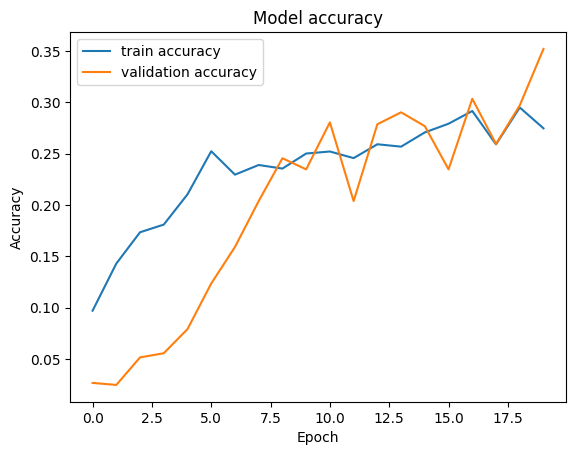

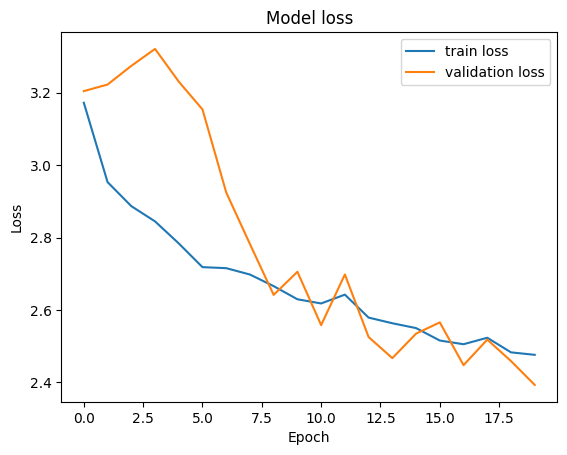

In [ ]:
model.save("cnnv1.keras")
model.save("cnnv1.h5")

import pickle

with open('cnnv1.pkl', 'wb') as file:
    pickle.dump(history.history, file)


def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_cnnv1')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_cnnv1')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)
    

# cnnv2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = [299, 299, 3]
n_classes = 20  
batch_size = 32  
nb_train_samples = 3583
nb_valid_samples = 1089

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)


input_layer = Input(shape=image_size)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(n_classes, kernel_regularizer=l2(0.005), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoints = ModelCheckpoint(filepath="cnnv2.keras", verbose=1, save_best_only=True)
csv_logger = CSVLogger("history_cnnv2.log")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator,
    validation_steps=nb_valid_samples // batch_size,
    epochs=20,
    verbose=1,
    callbacks=[csv_logger, checkpoints, reduce_lr]
)


Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1015 - loss: 3.1708
Epoch 1: val_loss improved from inf to 3.66275, saving model to cnnv2.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.1017 - loss: 3.1694 - val_accuracy: 0.0597 - val_loss: 3.6627 - learning_rate: 0.0010
Epoch 2/20
 14/111 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.1871 - loss: 2.7441
Epoch 2: val_loss did not improve from 3.66275
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.1933 - loss: 2.7191 - val_accuracy: 0.0741 - val_loss: 3.6834 - learning_rate: 0.0010
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.2194 - loss: 2.6398
Epoch 3: val_loss did not improve from 3.66275
111/111 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.2195 - loss: 2.6396 - val_accuracy: 0.0579 - val_loss: 5.2818 - learning_rate: 0.0010
Epoch 4/20
 14/111 ━━━━━━━━━━━━━━━━━━━━ 38s 393ms/step - accuracy: 0.2573 - loss: 2.5133
Epoch 4: val_loss did not improve from 3.66275
111/11

In [ ]:
model.save("cnnv2.keras")
model.save("cnnv2.h5")

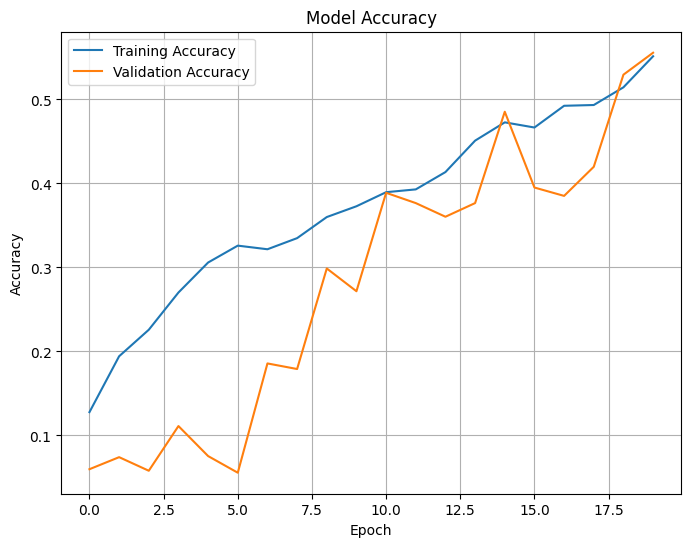

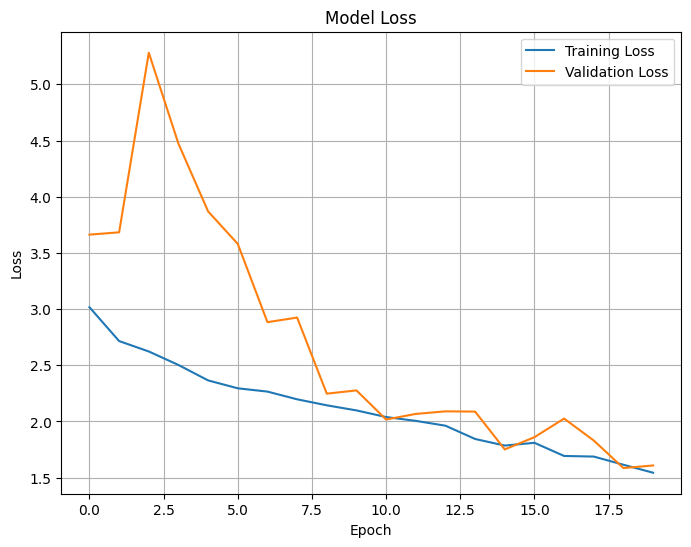

In [ ]:
import pickle

with open('cnnv2.pkl', 'wb') as file:
    pickle.dump(history.history, file)
import matplotlib.pyplot as plt

with open('cnnv2.pkl', 'rb') as file:
    history_data = pickle.load(file)

plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# cnnv3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

image_size = [299, 299, 3]  
n_classes = 20  
batch_size = 32  
nb_train_samples = 3583  
nb_valid_samples = 1089  

input_layer = Input(shape=image_size)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x) 
x = Dropout(0.6)(x)  
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)

predictions = Dense(n_classes, kernel_regularizer=l2(0.01), activation='softmax')(x)  

model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),  
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoints = ModelCheckpoint(filepath="cnnv3.keras", verbose=1, save_best_only=True)
csv_logger = CSVLogger("history_cnnv3.log")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator,
    validation_steps=nb_valid_samples // batch_size,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpoints, reduce_lr]
)


Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0870 - loss: 3.4959
Epoch 1: val_loss improved from inf to 3.43880, saving model to cnnv3.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.0872 - loss: 3.4946 - val_accuracy: 0.0506 - val_loss: 3.4388 - learning_rate: 1.0000e-04
Epoch 2/30
 14/111 ━━━━━━━━━━━━━━━━━━━━ 28s 295ms/step - accuracy: 0.1532 - loss: 3.1215
Epoch 2: val_loss did not improve from 3.43880
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.1637 - loss: 3.1011 - val_accuracy: 0.0617 - val_loss: 3.4637 - learning_rate: 1.0000e-04
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.1825 - loss: 3.0548
Epoch 3: val_loss did not improve from 3.43880
111/111 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.1826 - loss: 3.0545 - val_accuracy: 0.0533 - val_loss: 3.6766 - learning_rate: 1.0000e-04
Epoch 4/30
 14/111 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.2291 - loss: 2.9006
Epoch 4: val_loss did not improve from 3.

In [ ]:
model.save("cnnv3.keras")
model.save("cnnv3.h5")

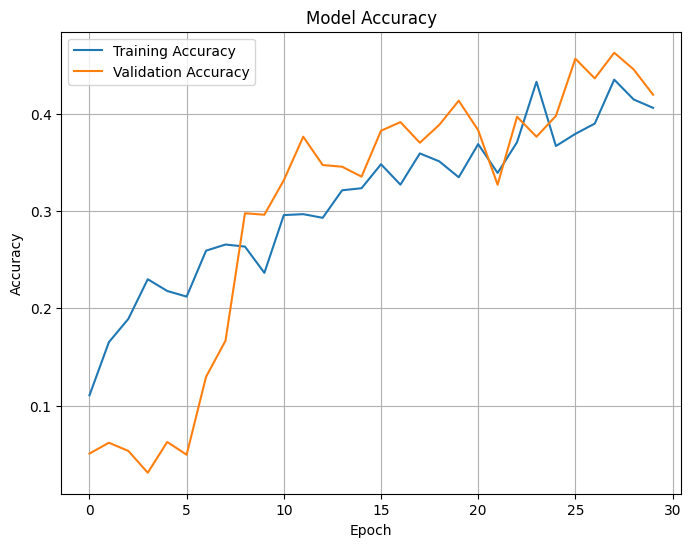

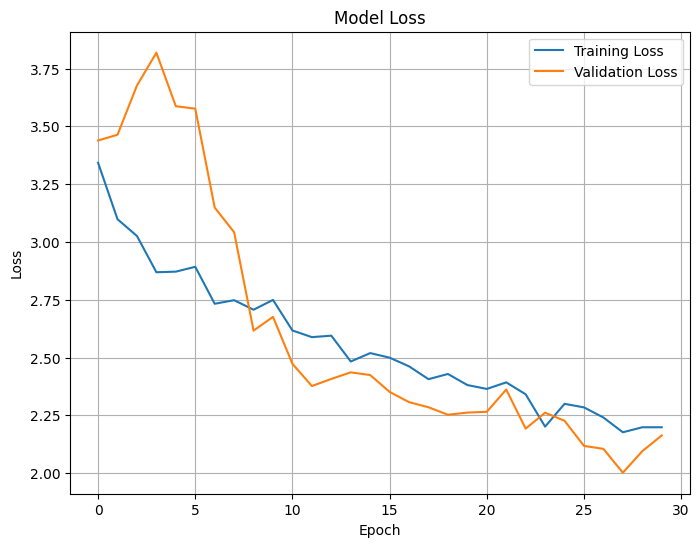

In [ ]:
import pickle

with open('cnnv3.pkl', 'wb') as file:
    pickle.dump(history.history, file)
import matplotlib.pyplot as plt

with open('cnnv3.pkl', 'rb') as file:
    history_data = pickle.load(file)

plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# cnnv4

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

image_size = [299, 299, 3]  
n_classes = 20  
batch_size = 32  
nb_train_samples = 3583  
nb_valid_samples = 1089 

input_layer = Input(shape=image_size)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(n_classes, kernel_regularizer=l2(0.01), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),  
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoints = ModelCheckpoint(filepath="cnnv4.keras", verbose=1, save_best_only=True)
csv_logger = CSVLogger("cnnv4.log")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

history = model.fit(
    train_generator,  
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator, 
    validation_steps=nb_valid_samples // batch_size,
    epochs=50, 
    verbose=1,
    callbacks=[csv_logger, checkpoints, reduce_lr]
)


Epoch 1/50


2024-11-19 08:58:39.937976: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[256,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,74,74]{3,2,1,0}, f32[32,256,74,74]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-19 08:58:40.179162: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.24133406s
Trying algorithm eng18{k11=2} for conv (f32[256,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,74,74]{3,2,1,0}, f32[32,256,74,74]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[]

 39/111 ━━━━━━━━━━━━━━━━━━━━ 1:03 879ms/step - accuracy: 0.0755 - loss: 3.5596

2024-11-19 08:59:52.514604: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[256,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,256,74,74]{3,2,1,0}, f32[28,256,74,74]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-19 08:59:52.574570: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.060076329s
Trying algorithm eng18{k11=2} for conv (f32[256,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,256,74,74]{3,2,1,0}, f32[28,256,74,74]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1160 - loss: 3.3859
Epoch 1: val_loss improved from inf to 3.54300, saving model to cnnv4.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.1164 - loss: 3.3842 - val_accuracy: 0.0478 - val_loss: 3.5430 - learning_rate: 1.0000e-04
Epoch 2/50
 14/111 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.2023 - loss: 3.0191
Epoch 2: val_loss did not improve from 3.54300
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.2245 - loss: 2.9579 - val_accuracy: 0.0556 - val_loss: 3.5929 - learning_rate: 1.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.2473 - loss: 2.8608
Epoch 3: val_loss did not improve from 3.54300
111/111 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.2475 - loss: 2.8604 - val_accuracy: 0.0524 - val_loss: 4.8326 - learning_rate: 1.0000e-04
Epoch 4/50
 14/111 ━━━━━━━━━━━━━━━━━━━━ 55s 569ms/step - accuracy: 0.2946 - loss: 2.7485
Epoch 4: val_loss did not improve from 3.54300
111/

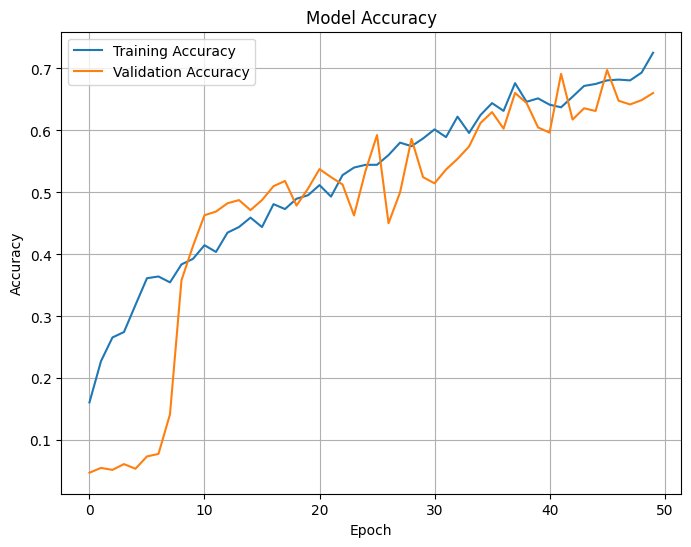

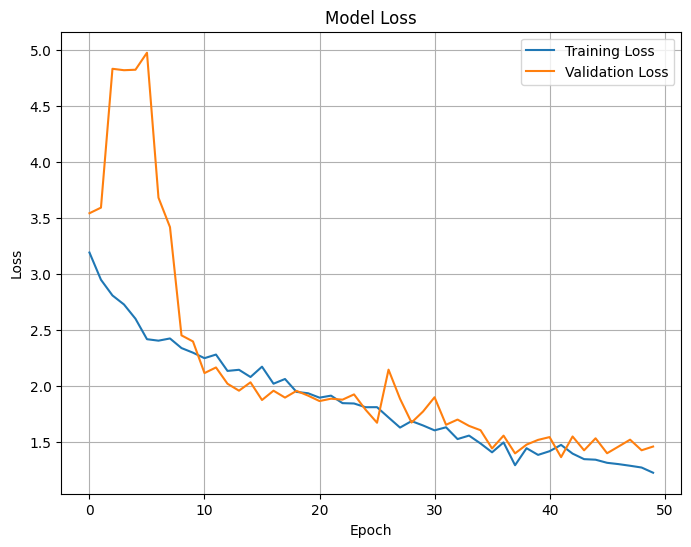

In [ ]:
model.save("cnnv4.keras")
model.save("cnnv4.h5")

import pickle

with open('cnnv4.pkl', 'wb') as file:
    pickle.dump(history.history, file)
import matplotlib.pyplot as plt

with open('cnnv4.pkl', 'rb') as file:
    history_data = pickle.load(file)

plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# improved_cnnv2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = [299, 299, 3]
n_classes = 20  
batch_size = 32  
nb_train_samples = 3583
nb_valid_samples = 1089

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)


input_layer = Input(shape=image_size)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(n_classes, kernel_regularizer=l2(0.005), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoints = ModelCheckpoint(filepath="improved_cnnv2.keras", verbose=1, save_best_only=True)
csv_logger = CSVLogger("history_improved_cnnv2.log")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator,
    validation_steps=nb_valid_samples // batch_size,
    epochs=50,
    verbose=1,
    callbacks=[csv_logger, checkpoints, reduce_lr]
)


In [ ]:
model.save("improved_cnnv2.keras")
model.save("improved_cnnv2.h5")

import pickle

with open('improved_cnnv2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# improved_cnnv21

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = [299, 299, 3]
n_classes = 20  
batch_size = 32  
nb_train_samples = 3583
nb_valid_samples = 1089

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)


input_layer = Input(shape=image_size)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(n_classes, kernel_regularizer=l2(0.005), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoints = ModelCheckpoint(filepath="improved_cnnv2.keras", verbose=1, save_best_only=True)
csv_logger = CSVLogger("history_improved_cnnv2.log")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=val_generator,
    validation_steps=nb_valid_samples // batch_size,
    epochs=50,
    verbose=1,
    callbacks=[csv_logger, checkpoints, reduce_lr]
)


In [ ]:
model.save("improved_cnnv21.keras")
model.save("improved_cnnv21.h5")

import pickle
with open('improved_cnnv21.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# InceptionV3

In [40]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

nb_train_samples = 3583
nb_valid_samples = 1089

image_size = [299 , 299]

inception = InceptionV3(input_shape = image_size + [3] , weights = "imagenet" , include_top = False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128 , activation = "relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes , kernel_regularizer = l2(0.005) , activation = "softmax")(x)

model = Model(inputs = inception.input , outputs = predictions)
model.compile(optimizer = SGD(lr=0.0001 , momentum = 0.9) , loss = "categorical_crossentropy" , metrics = ["accuracy"])

checkpoints = ModelCheckpoint(filepath = "v1_inceptionV3.keras" , verbose = 1 , save_best_only = True)
csv_logger = CSVLogger("history_v1_inceptionV3.log")

history = model.fit_generator(train_generator,
                             steps_per_epoch = nb_train_samples // batch_size,
                             validation_data = val_generator,
                             validation_steps = nb_valid_samples // batch_size,
                             epochs = 20,
                             verbose = 1,
                             callbacks = [csv_logger , checkpoints])

In [ ]:
model.save("v1_inceptionV3.keras")
model.save("v1_inceptionV3.h5")